In [98]:
from fastai.text import *
import html
import pandas as pd

## Load INSPIRE data

In [99]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('arxiv_data/')

In [100]:
CLAS_PATH=Path('arxiv_data/arxiv_clas')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('arxiv_data/arxiv_lm/')
LM_PATH.mkdir(exist_ok=True)

In [101]:
inspire_data = pd.read_pickle('arxiv_data/arXiv_classifier_data.df')

inspire_data = inspire_data.sample(frac=1).reset_index(drop=True)
inspire_data.columns = ['text', 'labels']
inspire_data = inspire_data[['labels', 'text']]

In [102]:
CLASSES = ["astro-ph", "cond-mat", "cs", "econ", "eess", "gr-qc", "hep-ex", "hep-lat", "hep-ph", "hep-th", "math", "math-ph", "nlin", "nucl-ex", "nucl-th", "physics", "q-bio", "q-fin","quant-ph", "stat"]

In [105]:
# Replace text labels with categorical labels
for i, cls in enumerate(CLASSES):
    mask = inspire_data.labels == cls
    inspire_data.loc[mask, 'labels'] = i

## Prepare data for the Language Model

In [106]:
# Split the data into training (80 %) and validation (20 % splits)

df_trn, df_val = sklearn.model_selection.train_test_split(
    inspire_data, test_size=0.2)

df_train = df_trn.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

trn_texts = np.array(df_trn['text'])
val_texts = np.array(df_val['text'])

In [107]:
print('{}, {}'. format(len(trn_texts), len(val_texts)))

91224, 22807


In [108]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)


(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

In [109]:
col_names = ['labels','text']

df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

## Language Model Tokens

In [110]:
chunksize=24000

In [111]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [112]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [113]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [114]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [115]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
0


In [116]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [117]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [118]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [119]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 962990),
 ('of', 619448),
 ('.', 610848),
 (',', 543737),
 ('-', 389688),
 ('>', 367607),
 ('<', 367482),
 ('and', 366056),
 ('a', 357791),
 ('in', 313066),
 ('to', 284095),
 ('$', 222797),
 ('we', 214849),
 ('\\', 205061),
 ('for', 182139),
 ('is', 181999),
 ('t_up', 164829),
 ('that', 141652),
 ('with', 134295),
 ('(', 125855),
 (')', 125721),
 ('on', 113288),
 ('1', 102255),
 ('this', 98140),
 ('\n', 94996)]

In [120]:
max_vocab = 60000
min_freq = 2

In [121]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [122]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [123]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [124]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [125]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [126]:
vs=len(itos)
vs,len(trn_lm)

(60002, 91224)

## wikitext103 conversion

In [31]:
# ! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

--2018-08-15 16:41:55--  http://files.fast.ai/models/wt103/
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘arxiv_data/models/wt103/index.html’

100%[======================================>] 857         --.-K/s   in 0s      

2018-08-15 16:41:55 (116 MB/s) - ‘arxiv_data/models/wt103/index.html’ saved [857/857]

Loading robots.txt; please ignore errors.
--2018-08-15 16:41:55--  http://files.fast.ai/robots.txt
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 404 Not Found
2018-08-15 16:41:55 ERROR 404: Not Found.

--2018-08-15 16:41:55--  http://files.fast.ai/models/wt103/?C=N;O=D
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘arxiv_data/models/wt103/index.html?C=N;O=D’

100%[========================

In [32]:
em_sz,nh,nl = 400,1150,3

In [33]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [34]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [35]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [36]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [37]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [38]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model

In [39]:
wd=1e-7
bptt=70
bs=32
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [40]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [41]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [42]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [43]:
learner.model.load_state_dict(wgts)

In [44]:
lr=1e-3
lrs = lr

In [45]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      4.510898   4.247742   0.327934  



[array([4.24774]), 0.3279337490225114]

In [46]:
learner.save('lm_last_ft')

In [47]:
learner.load('lm_last_ft')

In [48]:
learner.unfreeze()

In [49]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      4.360345   4.183772   0.331175  



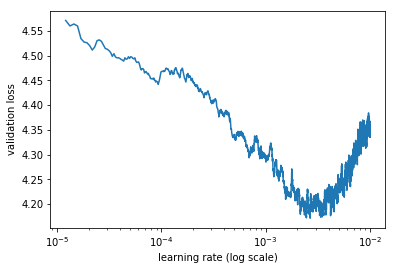

In [50]:
learner.sched.plot()

In [51]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                     
    0      4.00232    3.795107   0.365607  
    1      3.824843   3.659125   0.375728                     
    2      3.735348   3.591884   0.381428                     
    3      3.685263   3.556712   0.384914                     
    4      3.641319   3.53126    0.387582                     
    5      3.621329   3.511753   0.389417                     
    6      3.556279   3.500961   0.390633                     
    7      3.560474   3.488158   0.392176                     
    8      3.555607   3.476475   0.393147                     
    9      3.510984   3.468952   0.394375                     
    10     3.480767   3.461153   0.395138                     
    11     3.460912   3.454836   0.396077                     
    12     3.484984   3.445989   0.397051                     
    13     3.440452   3.441825   0.397491                     
    14     3.397595   3.439229   0.397979                     



[array([3.43923]), 0.397979301122342]

In [52]:
learner.save('lm1')

In [53]:
learner.save_encoder('lm1_enc')

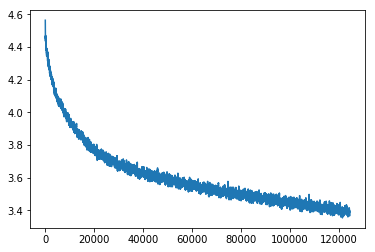

In [54]:
learner.sched.plot_loss()

## Classifier Tokens

In [127]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [128]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
0


In [129]:
df_trn

In [130]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [131]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [132]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [133]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [134]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

In [135]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [136]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))
print('{}, {}'.format(len(trn_labels), len(val_labels)))

91224, 22807


In [137]:
trn_clas = trn_clas[:-1]
# val_clas = val_clas[:100]
trn_labels = trn_labels[:-1]
# val_labels = val_labels[:100]
print(len(trn_clas))

91223


In [150]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 10

In [151]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [152]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
# trn_samp = SortSampler(trn_clas, key=lambda x: len(trn_clas[x]))
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [153]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [154]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [155]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [156]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [157]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [158]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [159]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [160]:
learn.freeze_to(-1)

 75%|███████▍  | 13637/18245 [16:02<05:25, 14.16it/s, loss=6.81]

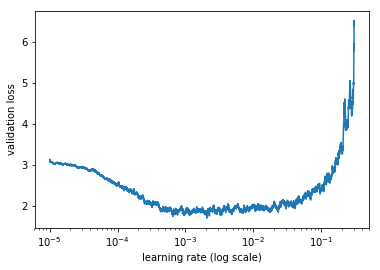

In [161]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [162]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                       
    0      1.74558    1.459856   0.567457  


[array([1.45986]), 0.5674573653844132]

In [163]:
learn.save('clas_0_bs10')

In [164]:
learn.load('clas_0_bs10')

In [165]:
learn.freeze_to(-2)

In [166]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                       
    0      1.473471   2.671593   0.674793  


[array([2.67159]), 0.6747928288041534]

In [167]:
learn.save('clas_1_bs10')

In [168]:
learn.load('clas_1_bs10')

In [169]:
learn.unfreeze()

In [170]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                        
    0      1.103335   31.549737  0.722147  
    1      1.137366   15.328642  0.776341                        
    2      1.016302   48.520933  0.783488                        
    3      0.894591   151.188578 0.785811                        
    4      0.662033   21.581354  0.803744                        
    5      0.733048   20.957136  0.792564                        
    6      0.648839   130.60272  0.795589                        
    7      0.674115   82.144006  0.809971                        
    8      0.507598   136.647579 0.797913                        
    9      0.557672   187.849651 0.759898                        
    10     0.416295   134.166202 0.797474                        
    11     0.432278   324.790633 0.769369                        
    12     0.447295   130.728384 0.745166                        
    13     0.388268   201.508889 0.805323                        


[array([201.50889]), 0.8053229234473355]

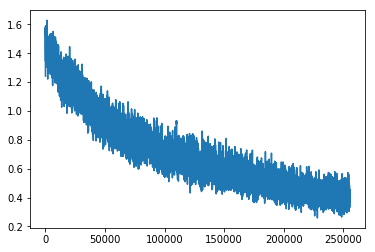

In [171]:
learn.sched.plot_loss()

In [172]:
learn.save('clas_2_bs10')

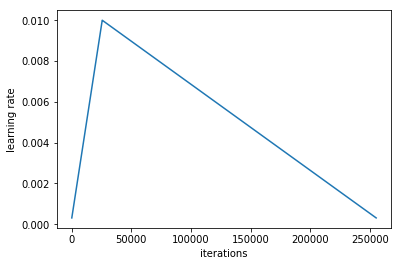

In [173]:
learn.sched.plot_lr()

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                          
    0      0.459526   0.442112   0.884939  
    1      0.447803   1.478697   0.876811                          
    2      0.442537   0.439345   0.891738                          
    3      0.399888   4.855816   0.895581                          
    4      0.283818   3.199698   0.890334                            
    5      0.31896    0.574976   0.898906                          
    6      0.279412   2.050404   0.895507                          
    7      0.318974   26.84656   0.889521                          
    8      0.293591   8.439013   0.893955                          
    9      0.301445   2.200844   0.89802                           
    10     0.246604   5.633811   0.895064                          
    11     0.285277   6.415017   0.896246                          
    12     0.202568   0.943813   0.894029                          
  1%|          | 162/30445 [00:34<1:47:23,  4.70it/s, loss=0.193]

## Make predictions

In [174]:
%%time

preds, target = learn.predict_with_targs()

CPU times: user 2min 17s, sys: 30.3 s, total: 2min 47s
Wall time: 2min 47s


In [175]:
# Calcualate the inference times
time_taken = 2 * 60 + 47
time_per_sample = time_taken / len(target)
print('Time per sample: {} s'.format(time_per_sample))
print('Samples per second: {}'.format(1/time_per_sample))

Time per sample: 0.0073223133248564035 s
Samples per second: 136.5688622754491


In [176]:
pred = preds.argmax(axis=1)

In [177]:
from sklearn.metrics import confusion_matrix

In [182]:
conf_mat = confusion_matrix(target, pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [183]:
# funtion to plot confusion matrices, will be needed later

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)

    print(cm)
    
    
    plt.title(title)
    plt.colorbar( )
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.94355 0.00179 0.00448 0.00224 0.00045 0.01478 0.00224 0.00045 0.00358 0.00045 0.00224 0.      0.00134
  0.00045 0.00493 0.01523 0.0009  0.00045 0.      0.00045]
 [0.0015  0.86587 0.00337 0.0015  0.      0.00037 0.      0.00187 0.      0.00487 0.0296  0.00562 0.0045
  0.      0.0015  0.05283 0.00525 0.00037 0.02023 0.00075]
 [0.00213 0.0017  0.86651 0.00106 0.02683 0.      0.      0.00021 0.      0.00021 0.05216 0.      0.00021
  0.      0.00021 0.0083  0.01086 0.00468 0.00234 0.02257]
 [0.      0.      0.14815 0.      0.      0.      0.      0.      0.      0.      0.14815 0.      0.
  0.      0.      0.      0.03704 0.25926 0.      0.40741]
 [0.01198 0.00599 0.53293 0.00599 0.31737 0.      0.      0.      0.      0.      0.05389 0.      0.
  0.      0.      0.04192 0.00599 0.00599 0.      0.01796]
 [0.09842 0.00351 0.00176 0.1775  0.      0.59578 0.      0.      0.00351 0.06151 0.02109 0.01054 0.00351
  0.00351 0.00351 0.01406 0.      0.      0.00176 0.

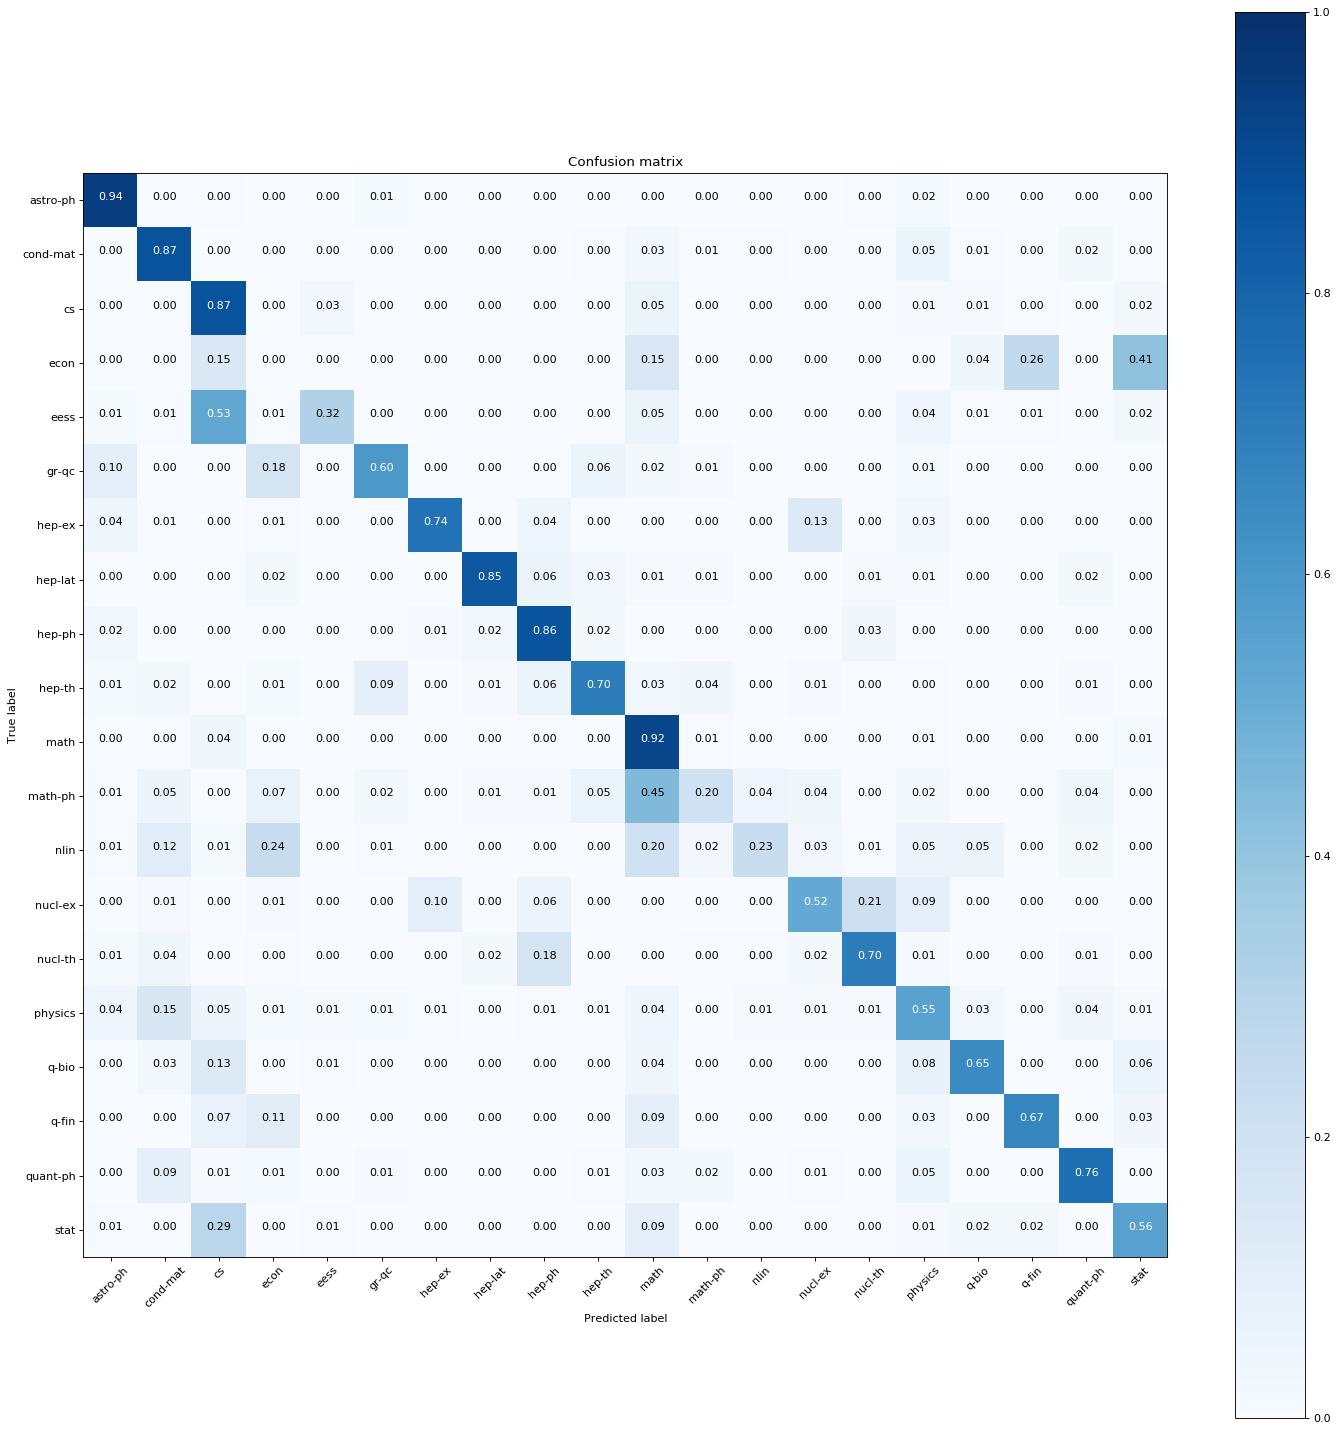

In [187]:
plt.figure(figsize=(18, 18), dpi=80)
plot_confusion_matrix(conf_mat, ["astro-ph", "cond-mat", "cs", "econ", "eess", "gr-qc", "hep-ex", "hep-lat", "hep-ph", "hep-th", "math", "math-ph", "nlin", "nucl-ex", "nucl-th", "physics", "q-bio", "q-fin","quant-ph", "stat"], normalize=True)
plt.show()